# A/B-тестирование

# Цели исследования:

Задача — провести оценку результатов A/B-теста новой рекомендательной системы товаров для пользователей. Мне предстоит оценить изменились ли продажи после внедрения изменений или нет.

Ожидаемый эффект: за 14 дней с момента регистрации пользователи покажут улучшение каждой метрики не менее, чем на 10%:
* конверсии в просмотр карточек товаров — событие product_page;
* просмотры корзины — product_cart;
* покупки — purchase;

В моем распоряжении есть датасет с действиями пользователей, техническое задание и несколько вспомогательных датасетов.

Нужно оценить корректность проведения теста и проанализировать его результаты.

Чтобы оценить корректность проведения теста:
* нужно удостовериться, что нет пересечений с конкурирующим тестом и нет пользователей, участвующих в двух группах теста одновременно;
* нужно проверить равномерность распределения пользователей по тестовым группам и правильность их формирования.

# Техническое задание

* Название теста: recommender_system_test;
* группы: А — контрольная, B — новая платёжная воронка;
* дата запуска: 2020-12-07;
* дата остановки набора новых пользователей: 2020-12-21;
* дата остановки: 2021-01-04;
* аудитория: в тест должно быть отобрано 15% новых пользователей из региона EU;
* назначение теста: тестирование изменений, связанных с внедрением улучшенной рекомендательной системы;
* ожидаемое количество участников теста: 6000.

# Описание данных

ab_project_marketing_events.csv — календарь маркетинговых событий на 2020 год.

Структура файла:
* name — название маркетингового события;
* regions — регионы, в которых будет проводиться рекламная кампания;
* start_dt — дата начала кампании;
* finish_dt — дата завершения кампании.

final_ab_new_users.csv — пользователи, зарегистрировавшиеся с 7 до 21 декабря 2020 года.

Структура файла:
* user_id — идентификатор пользователя;
* first_date — дата регистрации;
* region — регион пользователя;
* device — устройство, с которого происходила регистрация.

final_ab_events.csv — действия новых пользователей в период с 7 декабря 2020 по 4 января 2021 года.

Структура файла:
* user_id — идентификатор пользователя;
* event_dt — дата и время события;
* event_name — тип события;
* details — дополнительные данные о событии. Например, для покупок, purchase, в этом поле хранится стоимость покупки в долларах.

final_ab_participants.csv — таблица участников тестов.

Структура файла:
* user_id — идентификатор пользователя;
* ab_test — название теста;
* group — группа пользователя.

# Шаг 1. Загрузка и первичный анализ данных

In [1]:
pip install -U kaleido

     |████████████████████████████████| 79.9 MB 71 kB/s s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [2]:
# Загрузим необходимые для работы библиотеки

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import plotly.graph_objects as go
import plotly.express as px
import math as mth
from scipy import stats as st
import warnings
warnings.filterwarnings('ignore')
from statsmodels.stats.weightstats import ztest as ztest

In [3]:
# Загрузим датасеты

try:
    final_ab_events = pd.read_csv('https://code.s3.yandex.net/datasets/final_ab_events.csv')
    ab_project_marketing_events = pd.read_csv('https://code.s3.yandex.net/datasets/ab_project_marketing_events.csv')
    final_ab_new_users = pd.read_csv('https://code.s3.yandex.net/datasets/final_ab_new_users.csv')
    final_ab_participants = pd.read_csv('https://code.s3.yandex.net/datasets/final_ab_participants.csv')
except:
    final_ab_events = pd.read_csv('final_ab_events.csv')
    ab_project_marketing_events = pd.read_csv('final_ab_marketing_events.csv')
    final_ab_new_users = pd.read_csv('final_ab_new_users.csv')
    final_ab_participants = pd.read_csv('final_ab_participants.csv')

Проведем первичный анализ данных по каждому из датасетов:

In [4]:
final_ab_events.head()

,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99


In [5]:
ab_project_marketing_events.head()

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11


In [6]:
final_ab_new_users.head()

,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone


In [7]:
final_ab_participants.head()

,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,482F14783456D21B,B,recommender_system_test


Мы загрузили данные всех датасетов, оценили первые 5 строк каждого датасета. Переходим к предобработке данных.

# Шаг 2. Предобработка данных

# Оценим каждый датасеты с точки зрения типов данных в колонках, а также на наличие пропусков:

In [8]:
final_ab_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     440317 non-null  object 
 1   event_dt    440317 non-null  object 
 2   event_name  440317 non-null  object 
 3   details     62740 non-null   float64
dtypes: float64(1), object(3)
memory usage: 13.4+ MB


В датасете 4 колонки и 440317 строк. В колонке 'details' много пропусков, но судя по ее описанию, такое может быть (в дополнительных данных могут быть данные, а могут не быть). В колонке 'event_dt' содержатся данные по дате, но при этом они имеют тип данных object. Приведем колонку к типу данных 'datetime':

In [9]:
final_ab_events['event_dt'] = pd.to_datetime(final_ab_events['event_dt'])

Проверим результат:

In [10]:
final_ab_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   user_id     440317 non-null  object        
 1   event_dt    440317 non-null  datetime64[ns]
 2   event_name  440317 non-null  object        
 3   details     62740 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 13.4+ MB


In [11]:
ab_project_marketing_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       14 non-null     object
 1   regions    14 non-null     object
 2   start_dt   14 non-null     object
 3   finish_dt  14 non-null     object
dtypes: object(4)
memory usage: 576.0+ bytes


В датасете 4 колонки и 14 строк. Пропусков нигде нет. В колонках 'start_dt' и 'finish_dt' содержатся данные по дате, но при этом они имеют тип данных object. Приведем колонки к типу данных 'datetime':

In [12]:
ab_project_marketing_events['start_dt'] = pd.to_datetime(ab_project_marketing_events['start_dt'])
ab_project_marketing_events['finish_dt'] = pd.to_datetime(ab_project_marketing_events['finish_dt'])

Проверим результат:

In [13]:
ab_project_marketing_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   name       14 non-null     object        
 1   regions    14 non-null     object        
 2   start_dt   14 non-null     datetime64[ns]
 3   finish_dt  14 non-null     datetime64[ns]
dtypes: datetime64[ns](2), object(2)
memory usage: 576.0+ bytes


In [14]:
final_ab_new_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     61733 non-null  object
 1   first_date  61733 non-null  object
 2   region      61733 non-null  object
 3   device      61733 non-null  object
dtypes: object(4)
memory usage: 1.9+ MB


В датасете 4 колонки и 61733 строки. Пропусков нигде нет. В колонке 'first_date' содержатся данные по дате, но при этом они имеют тип данных object. Приведем колонку к типу данных 'datetime':

In [15]:
final_ab_new_users['first_date'] = pd.to_datetime(final_ab_new_users['first_date'])

Проверим результат:

In [16]:
final_ab_new_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     61733 non-null  object        
 1   first_date  61733 non-null  datetime64[ns]
 2   region      61733 non-null  object        
 3   device      61733 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 1.9+ MB


In [17]:
final_ab_participants.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18268 entries, 0 to 18267
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  18268 non-null  object
 1   group    18268 non-null  object
 2   ab_test  18268 non-null  object
dtypes: object(3)
memory usage: 428.3+ KB


В датасете 3 колонки и 18268 строк. Пропусков нигде нет. Типы данных в колонках корректные.

# Оценим датасеты на наличие дубликатов:

In [18]:
final_ab_events.duplicated().sum()

0

In [19]:
ab_project_marketing_events.duplicated().sum()

0

In [20]:
final_ab_new_users.duplicated().sum()

0

In [21]:
final_ab_participants.duplicated().sum()

0

Предобработка завершена, мы оценили:
* размеры датасетов;
* наличие пропусков (есть только в 'final_ab_events' в столбце 'details', что вполне объяснимо);
* корректность типов данных столбцов (все столбцы с данными про даты привели к типу данных 'datetime');
* наличие дублей (не обнаружены).

# Оценим другие параметры датасета:

In [22]:
# Количество тестов в датасете:
final_ab_participants.groupby(['ab_test', 'group']).agg({'user_id': 'nunique'})

user_id
ab_test                 group         
interface_eu_test       A         5831
                        B         5736
recommender_system_test A         3824
                        B         2877

В датасете содержатся данные по 2 тестам: "interface_eu_test" и "recommender_system_test"

In [23]:
# Количество регионов в датасете:
final_ab_new_users.groupby(['region']).agg({'user_id': 'nunique'})

,user_id
region,
APAC,3153
CIS,3155
EU,46270
N.America,9155


В датасете содержатся данные по 4 регионам: "APAC", "CIS", "EU" и "N.America"

In [24]:
# Количество регионов в устройств:
final_ab_new_users.groupby(['device']).agg({'user_id': 'nunique'})

,user_id
device,
Android,27520
Mac,6084
PC,15599
iPhone,12530


В датасете содержатся данные по 4 устройствам: "Android", "Mac", "PC" и "iPhone"

# Шаг 3. Оценка корректности проведения теста

# Проверим соответствие данных требованиям технического задания

In [25]:
final_ab_participants.head()

,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,482F14783456D21B,B,recommender_system_test


Название теста - 'recommender_system_test' - все верно

In [26]:
final_ab_participants.groupby(['ab_test', 'group']).agg({'user_id': 'nunique'})

user_id
ab_test                 group         
interface_eu_test       A         5831
                        B         5736
recommender_system_test A         3824
                        B         2877

Группы А и В в тесте присутствуют, это соответствует требования ТЗ. При этом в датасете есть и данные по другому тесту - 'interface_eu_test'. Посмотрим, есть ли между этими тестами пересечения по пользователям:

In [27]:
users_for_tests = final_ab_participants.groupby('user_id').agg({'ab_test': 'nunique'}).sort_values(by = 'ab_test', ascending = False).reset_index()
users_for_two_tests = users_for_tests.loc[users_for_tests['ab_test'] == 2]
users_for_two_tests_final = users_for_two_tests['user_id']
len(users_for_two_tests_final)

1602

В оба теста одновременно входят 1602 пользователя. Посмотрим, в каких группах есть пересечения:

In [28]:
users_for_two_tests_final = final_ab_participants.query('user_id in @users_for_two_tests_final').reset_index(drop=True)
users_for_two_tests_final.groupby(['ab_test', 'group']).agg({'user_id': 'nunique'})

user_id
ab_test                 group         
interface_eu_test       A          819
                        B          783
recommender_system_test A          921
                        B          681

Поскольку наличие одних и тех же пользователей в обоих группах могло внести в результаты теста искажения, мы вынуждены удалить таких пользователей. Оставим в датасете только данные по нашему тесту:

In [29]:
final_ab_participants = final_ab_participants.query('ab_test == "recommender_system_test"')

In [30]:
final_ab_participants.groupby('group').agg({'user_id': 'nunique'})

,user_id
group,
A,3824
B,2877


В группе В почти на 1000 пользователей меньше, чем в группе А. Далее объединим нужны таблицы:

In [31]:
final_users_test = final_ab_participants
final_users_test = final_users_test.merge(final_ab_new_users, on='user_id')

In [32]:
final_ab_participants['user_id'].nunique()

6701

Согласно ТЗ у нас ожидалось 6000 пользователей - участников теста, по этому параметру также все хорошо

In [33]:
final_ab_new_users['first_date'].max()

Timestamp('2020-12-23 00:00:00')

В датасете есть данные вплоть до 23.12.2020. По условиям ТЗ данные должны быть ограничены 21.12.2020, обрежем лишнее:

In [34]:
final_ab_new_users = final_ab_new_users[final_ab_new_users['first_date'] <= "2020-12-21 00:00:00"]

Проверим изменения:

In [35]:
test_start = final_ab_new_users['first_date'].min()
test_start

Timestamp('2020-12-07 00:00:00')

In [36]:
test_end = final_ab_new_users['first_date'].max()
test_end

Timestamp('2020-12-21 00:00:00')

In [37]:
final_ab_new_users_participants = final_ab_new_users.merge(final_ab_participants, on='user_id', how='left')
print('Дата начала набора новых пользователей:', final_ab_new_users_participants['first_date'].min())
print('Дата окончания набора новых пользователей:', final_ab_new_users_participants['first_date'].max())

Дата начала набора новых пользователей: 2020-12-07 00:00:00
Дата окончания набора новых пользователей: 2020-12-21 00:00:00


С датами начала и окончания набора новых пользователей в датасете все в порядке

Проверим процент новых пользователей из региона EU:

In [38]:
eu_test_users = final_ab_new_users.query('region=="EU"')
eu_users = final_users_test.query('region == "EU" and first_date >= @test_start and first_date <= @test_end')
eu_users.shape[0]/eu_test_users.shape[0]

0.15

In [39]:
print('Новых пользователей из региона EU:', \
      round(final_users_test[final_users_test['region'] == 'EU'].shape[0] / \
      final_ab_new_users[final_ab_new_users['region'] == 'EU'].shape[0] * 100),'%')

Новых пользователей из региона EU: 15 %


Процент новых пользователей из региона EU соответствует ТЗ, все в порядке

Проверим, проводились ли во время теста другие маркетинговые активности:

In [40]:
ab_project_marketing_events.query('"2020-12-07" < start_dt < "2021-01-03"')

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
10,CIS New Year Gift Lottery,CIS,2020-12-30,2021-01-07


Параллельно с нашим тестом шли еще 2 маркетинговые активности, но только "Christmas&New Year Promo" проводился в том числе в регионе EU. При этом это мероприятие началось после того, как мы взяли новых пользователей, поэтому на их набор оно повлиять не могло. Другой вопрос, что оно проводилось в то время, как шло наше исследование, то могло повлиять на его результаты.

Проверим корректность даты остановки теста:

In [41]:
final_users_test = final_users_test.merge(final_ab_events, on = 'user_id')
events_by_day = final_users_test.groupby('event_dt')['event_name'].count().reset_index()
events_by_day['date'] = events_by_day['event_dt'].dt.date
events_by_day['date'].max()

datetime.date(2020, 12, 30)

Последней датой, по которой доступны данные в датасете, является 30.12.2020. При этом по условиям ТЗ тест длился до 4 января включительно, т.е. налицо неполные данные в датасете с точки зрения ТЗ (пункта про дату окончания теста).

Проверим, есть ли пользователи, которые одновремено попали в обе группы теста - А и В:

In [42]:
group_a = final_ab_participants.query('group == "A"') 
group_b = final_ab_participants.query('group == "B"') 

group_a_b = list(np.intersect1d(group_a['user_id'], group_b['user_id']))
print ('Число пользователей, попавших в обе группы сразу = ', len(group_a_b))

Число пользователей, попавших в обе группы сразу =  0


Пользователей, которые одновремено попали в обе группы теста - А и В - не обраружено

Отфильтруем пользователей, которые участвовали в тесте более 14 дней (т.е. с лайфтаймом более 14 дней):

In [43]:
# добавим в табличку данные по лайфтайму
final_users_test['lifetime'] = (final_users_test['event_dt'] - final_users_test['first_date']).dt.days
# добавим фильтр
final_users_test = final_users_test.query('lifetime < 14')

Проверим полученный результат:

In [44]:
final_users_test['lifetime'].nunique()

14

# Выводы по качеству исходных данных

В этом разделе мы проверили соответствие данных в датасетах поставленному ТЗ. По результатам анализа были найдены следующие недочеты:
* В датасете были обнаружены данные и по другому тесту - 'interface_eu_test’. Причем, пользователи в этом тесте частично пересекались с пользователями нашего теста, поэтому таких повторяющихся людей пришлось удалить, что уменьшило объем данных для исследования.
* Выяснилось, что в группе В почти на 1000 пользователей меньше, чем в группе А. Неравномерность распределения пользователей по группам теста – это минус.
* В датасете были найдены данные вплоть до 23.12.2020, хотя по условиям ТЗ данные должны быть ограничены 21.12.2020. Лишние данные обрезали.
* Параллельно с нашим тестом шли еще 2 маркетинговые активности, причем "Christmas&New Year Promo" проводился в том числе в регионе EU. Хотя это мероприятие началось после того, как мы взяли новых пользователей, но оно проводилось в то время, как шло наше исследование, то могло повлиять на его результаты.
* В датасете не хватает данных в период с 30 декабря по 4 января, т.е. мы не имеем доступа к данным за почти 6 полных дней.

Как видно из перечисленных выше пунктов, недочетов в исходных данных слишком много.

# Шаг 4. Исследовательский анализ данных

# Проверим, одинаково ли распределено количество событий на пользователя в выборке:

In [45]:
events_by_users = final_users_test.groupby(['group', 'user_id'], as_index=False).agg({'user_id': 'nunique','event_name':'count'})

for i in ['A', 'B']:
    print('Среднее кол-во событий на пользователя группы {} равно {}\n'.format(
        i,
        events_by_users.query('group == @i')['event_name'].mean().round()
    ))

Среднее кол-во событий на пользователя группы A равно 7.0

Среднее кол-во событий на пользователя группы B равно 5.0



В среднем пользователи из группы А делают на 2 события больше, чем пользователи группы Б. Визуализируем эти данные:

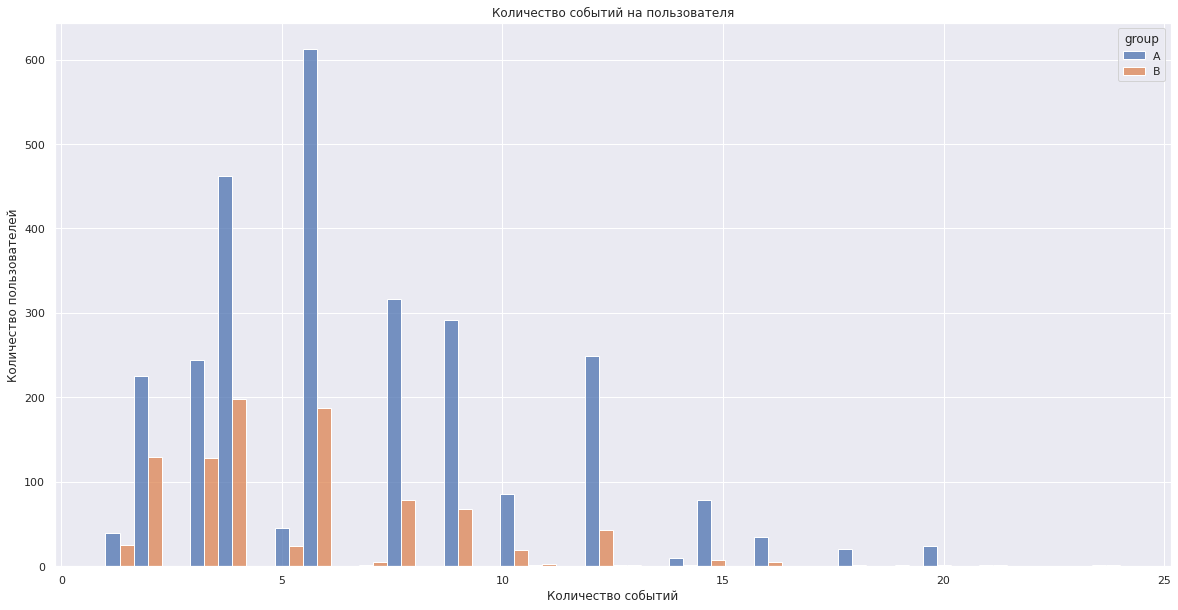

In [46]:
plt.figure(figsize = (20, 10))
sns.histplot(data=events_by_users, x='event_name', hue='group', multiple='dodge')
plt.title('Количество событий на пользователя')
plt.xlabel('Количество событий')
plt.ylabel('Количество пользователей')
plt.show()

# Проверим распределение событий и пользователей по дням:

In [47]:
final_users_test['event_dt'] = final_users_test['event_dt'].dt.date
events_by_date = (final_users_test.groupby(['event_dt', 'group'], as_index=False)['user_id'].count().rename(columns={'user_id':'events_count'}))
events_by_date.head()

,event_dt,group,events_count
0,2020-12-07,A,331
1,2020-12-07,B,378
2,2020-12-08,A,341
3,2020-12-08,B,252
4,2020-12-09,A,385


Визуализируем полученные данные:

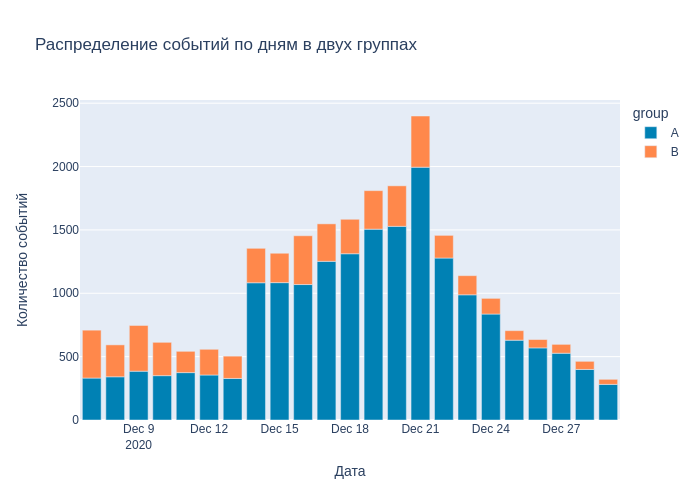

In [48]:
fig = px.bar(events_by_date, x='event_dt', y='events_count', color='group', 
             title='Распределение событий по дням в двух группах', 
             color_discrete_sequence=['#0081B4', '#FF884B'])
fig.update_xaxes(title_text='Дата')
fig.update_yaxes(title_text='Количество событий')

fig.show("png")

Тест запустили 7 декабря, 14 декабря пошел резкий рост числа событий с выходом на пик 21 декабря. Далее пошло их снижение вплоть до 30 декабря. Сам тест длился до 4 января, но данные по нему либо утеряны, либо событий не было в этот период. Во втором случае есть вероятность, что 30 декабря тоже было больше событий, но на этот день также пришлась часть потерь данных.

# Проверим, как меняется конверсия в воронке в выборках на разных этапах

In [49]:
event_conv = final_users_test.groupby(['event_name']).agg({'user_id':['count', 'nunique']}).reset_index()
event_conv.columns = ['event', 'user_id_count', 'user_id_unique']
event_conv = event_conv.sort_values('user_id_count', ascending=False)
event_conv['event_per_user'] = event_conv['user_id_count'] / event_conv['user_id_unique']
event_conv

,event,user_id_count,user_id_unique,event_per_user
0,login,10794,3674,2.937942
2,product_page,6684,2303,2.902301
3,purchase,3232,1128,2.865248
1,product_cart,3146,1079,2.915663


Воронка делится на 4 этапа:
* login - пользователь попадает на сайт
* product_page - посмотрел попадает на товарную карточку
* product_cart - добавил товар в корзину
* purchase - оплатил покупку

Напишем функции для будущей визуализации воронки конверсий по группам А и В:

In [50]:
funnel_A = final_users_test[final_users_test['group']=="A"].groupby('event_name').agg({'event_name':'count', 'user_id':'nunique'})
funnel_A.columns = ['event_count','user_count']
funnel_A = funnel_A.sort_values(by = 'event_count', ascending = False).reset_index().reindex([0,1,3,2])

funnel_B = final_users_test[final_users_test['group']=="B"].groupby('event_name').agg({'event_name':'count', 'user_id':'nunique'})
funnel_B.columns = ['event_count','user_count']
funnel_B = funnel_B.sort_values(by = 'event_count', ascending = False).reset_index()

Визуализируем полученные данные:

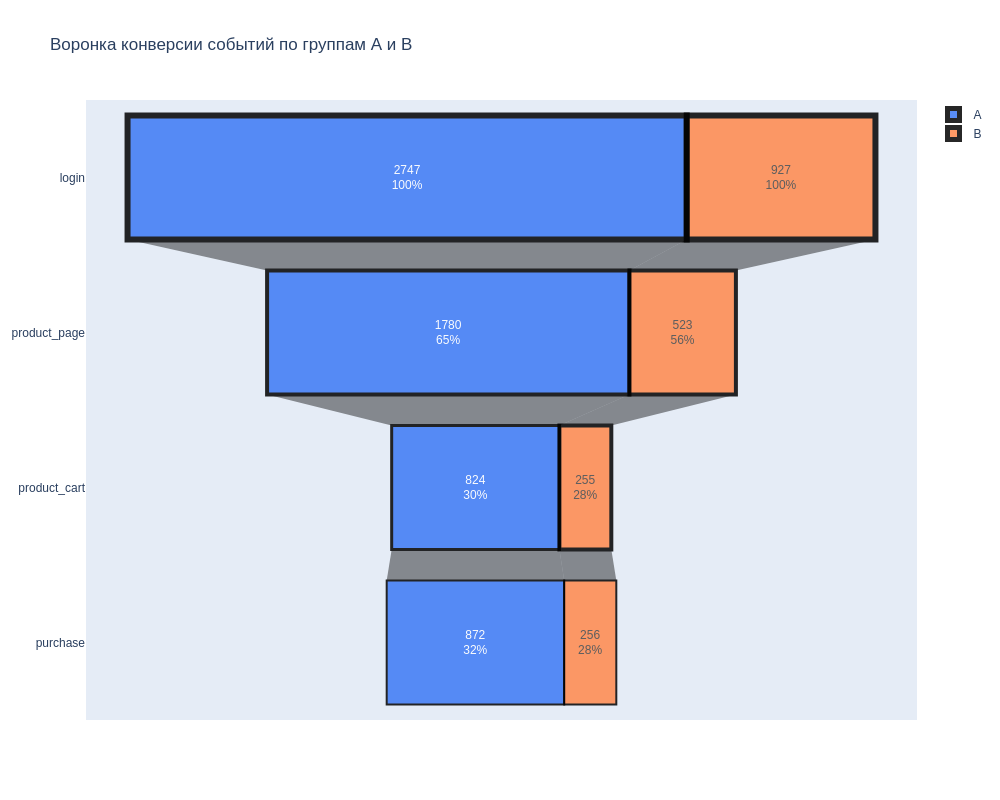

In [51]:
fig = go.Figure()

fig.add_trace(go.Funnel(
    name = 'A',
    y = funnel_A['event_name'],
    x = funnel_A['user_count'],
    opacity = 0.85, marker = {"color": ["#3C79F5", "#3C79F5", "#3C79F5", "#3C79F5"],
    "line": {"width": [6, 4, 3, 2, 1], "color": ["black", "black", "black", "black"]}},
    textinfo = "value+percent initial"))

fig.add_trace(go.Funnel(
    name = 'B',
    orientation = "h",
    y = funnel_B['event_name'],
    x = funnel_B['user_count'],
    opacity = 0.85, marker = {"color": ["#FF884B", "#FF884B", "#FF884B", "#FF884B"],
    "line": {"width": [6, 4, 4, 2, 1], "color": ["black", "black", "black", "black"]}},
    textposition = "inside",
    textinfo = "value+percent initial"))

fig.update_layout(title_text = 'Воронка конверсии событий по группам А и В', width=1000, height=800)
fig.show("png")

По воронке видно следующее:

Группа А:

* Из 100% пришедших на сайт 65% перешли на товарную карточку;
* 32% совершили оплату покупки;
* 30% добавили товар в корзину.

Группа В:

* Из 100% пришедших на сайт 56% перешли на товарную карточку;
* 28% совершили оплату покупки;
* 28% добавили товар в корзину.

Получается, что показатели группы А лучше, чем у группы В на каждом из этапов воронки. 

Необычно выглядит то, что у группы А добавивших товар в корзину меньше, чем оплативших его. Это может быть объяснено тем, что на сайте есть функция "Купить в 1 клик", когда для покупки товара не требуется опускать его в корзину.

# Особенности данных, которые нужно учесть, прежде чем приступать к A/B-тестированию

* В датасете были также данные по другому тесту - 'interface_eu_test', мы их убрали.
* Параллельно с нашим тестом в регионе EU шло еще одно маркетинговое мероприятие - "Christmas&New Year Promo". Оно началось после того, как мы взяли новых пользователей, поэтому на их набор не повлияло. При этом оно проводилось в то время, как шло наше исследование, это могло повлиять на его результаты.
* В группе В оказалось почти на 1000 пользователей меньше, чем в группе А.
* В среднем кол-во событий на пользователя группы A было на 1 больше, чем кол-во событий на пользователя группы B.
* В датасете нет данных с 30-го декабря (частично) и по 4 января (включительно). Это может быть связано как с потерей данных, так и с отсутствием событий в эти дни (все-таки праздники). Первое вероятнее.

# Шаг 5. A/B-тестирование

In [52]:
final_users_test.head()

,user_id,group,ab_test,first_date,region,device,event_dt,event_name,details,lifetime
0,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-07,purchase,99.99,0
2,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-07,product_cart,NaN,0
4,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-07,product_page,NaN,0
6,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-07,login,NaN,0
8,A7A3664BD6242119,A,recommender_system_test,2020-12-20,EU,iPhone,2020-12-20,product_page,NaN,0


In [53]:
# заменим тип данных в event_dt снова на 'datetime'
final_users_test['event_dt'] = pd.to_datetime(final_users_test['event_dt'])

In [54]:
conversion = (final_users_test.groupby(['lifetime', 'group', 'event_name'], as_index=False)['user_id'].count()
                  .rename(columns={'user_id':'events_count'}))
conversion.head()

,lifetime,group,event_name,events_count
0,0,A,login,2738
1,0,A,product_cart,823
2,0,A,product_page,1777
3,0,A,purchase,869
4,0,B,login,911


Создадим датасет с событиями 'product_page':

In [55]:
product_pages = conversion.query('event_name == "product_page"')
product_pages['events_cumsum'] = product_pages.groupby('group')['events_count'].cumsum()
a_product_pages = round((product_pages.iloc[-2]['events_cumsum'] - product_pages.iloc[0]['events_cumsum']) 
                        / product_pages.iloc[0]['events_cumsum'], 3) 
b_product_pages = round((product_pages.iloc[-1]['events_cumsum'] - product_pages.iloc[1]['events_cumsum']) 
                        / product_pages.iloc[1]['events_cumsum'], 3)

Создадим датасет с событиями 'product_cart':

In [56]:
product_carts = conversion.query('event_name == "product_cart"')
product_carts['events_cumsum'] = product_carts.groupby('group')['events_count'].cumsum()
a_product_carts = round((product_carts.iloc[-2]['events_cumsum'] - product_carts.iloc[0]['events_cumsum']) 
                        / product_carts.iloc[0]['events_cumsum'], 3) 
b_product_carts = round((product_carts.iloc[-1]['events_cumsum'] - product_carts.iloc[1]['events_cumsum']) 
                        / product_carts.iloc[1]['events_cumsum'], 3)

Создадим датасет с событиями 'purchases':

In [57]:
purchases = conversion.query('event_name == "purchase"')
purchases['events_cumsum'] = purchases.groupby('group')['events_count'].cumsum()
a_purchases = round((purchases.iloc[-2]['events_cumsum'] - purchases.iloc[0]['events_cumsum']) 
                     / purchases.iloc[0]['events_cumsum'], 3) 
b_purchases = round((purchases.iloc[-1]['events_cumsum'] - purchases.iloc[1]['events_cumsum']) 
                    / purchases.iloc[1]['events_cumsum'], 3)

Оценим полученные результаты:

In [58]:
print("Группа А - переход на товарную страницу:", a_product_pages)
print("Группа B - переход на товарную страницу:", b_product_pages, end='\n\n')
print('---------------------------------------------------------------------------------------------------------')
print("Группа A - добавление товара в корзину:", a_product_carts)
print("Группа B - добавление товара в корзину:", b_product_carts, end='\n\n')
print('---------------------------------------------------------------------------------------------------------')
print("Группа А - оплата товара:", a_purchases)
print("Группа B - оплата товара:", b_purchases)

Группа А - переход на товарную страницу: 2.023
Группа B - переход на товарную страницу: 1.575

---------------------------------------------------------------------------------------------------------
Группа A - добавление товара в корзину: 2.032
Группа B - добавление товара в корзину: 1.604

---------------------------------------------------------------------------------------------------------
Группа А - оплата товара: 1.99
Группа B - оплата товара: 1.506


Выводы:

Переход на товарную страницу, динамика за 2 недели с дня регистрации пользователя:

* Группа А - рост на 102,3%
* Группа B - рост на 57,5%

Добавление товара в корзину, динамика за 2 недели с дня регистрации пользователя:

* Группа А - рост на 103,2%
* Группа B - рост на 60,4%

Оплата товара, динамика за 2 недели с дня регистрации пользователя:

* Группа А - рост на 99 %
* Группа B - рост на 50,6%

# Проверка статистической разницы долей z-критерием

Сравним пропорции основных метрик: 'product_page', 'product_cart' и 'purchase' с помощью z-критерия.

H0: Доли значений метрик в группах равны.

H1: Доли значений метрик в группах не равны.

Критический уровень значимости (альфа) будем рассчитывать с помощью поправки Бонферрони, т.к. будем проводить множественные тесты на одинаковом наборе данных (без сбора новых наблюдений). Возьмем альфа = 0.05, а с поправкой альфа = 0.05 / 3 = 0.016.

Поскольку число пользователей в разных группах отличается, будем проверять z-критерием количество событий на одного пользователя, чтобы компенсировать эту разницу.

In [59]:
# таблица по lifetime, group, + количество событий
users_count = (final_users_test.groupby(['lifetime','group'], as_index=False)['user_id'].nunique()
               .rename(columns={'user_id':'users_count'}))

# события product_page
product_pages = product_pages.merge(users_count, on=['lifetime', 'group'])
product_pages['event_by_user'] = product_pages['events_count'] / product_pages['users_count']

# события product_cart
product_carts = product_carts.merge(users_count, on=['lifetime', 'group'])
product_carts['event_by_user'] = product_carts['events_count'] / product_carts['users_count']

# события purchase
purchases = purchases.merge(users_count, on=['lifetime', 'group'])
purchases['event_by_user'] = purchases['events_count'] / purchases['users_count']

Оценим средние значения метрик:

In [60]:
print('Тип события product_pages')
display(product_pages.groupby('group')['event_by_user'].mean())
print('Тип события product_carts')
display(product_carts.groupby('group')['event_by_user'].mean())
print('Тип события purchases')
display(purchases.groupby('group')['event_by_user'].mean())

Тип события product_pages


group
A    0.643813
B    0.525895
Name: event_by_user, dtype: float64

Тип события product_carts


group
A    0.295753
B    0.256690
Name: event_by_user, dtype: float64

Тип события purchases


group
A    0.308745
B    0.248406
Name: event_by_user, dtype: float64

Напишем функцию для расчета z-теста:

In [61]:
def func_z_test(event):
    z_test = ztest(event.query('group == "A"')['event_by_user'], 
                   event.query('group == "B"')['event_by_user'], value=0)[1]
    print("p-value:", z_test)

In [62]:
func_z_test(product_pages)

p-value: 2.32898544796704e-13


In [63]:
func_z_test(product_carts)

p-value: 0.008374594187157861


In [64]:
func_z_test(purchases)

p-value: 1.455949693254727e-06


Выводы:

Для двух метрик ('product_pages' и 'purchases') p-value больше альфы, поэтому в этих случаях отвергаем нулевую гипотезу: между долями есть значимая разница.

В случае с метрикой 'product_carts' p-value меньше альфы, поэтому в этом случае не отвергаем нулевую гипотезу: между долями нет значимой разницы.

# Результаты тестирования и выводы

Тестирование проведено некорректно, поскольку:
* Многие пользователи попали еще в один тест - 'interface_eu_test'.
* Параллельно с нашим тестом в регионе EU шло еще одно маркетинговое мероприятие - "Christmas&New Year Promo", что могло повлиять на его результаты.
* Пользователи в группах были распределены неравномерно: в группе В оказалось почти на 1000 пользователей меньше, чем в группе А.
* В датасете отсутствовали данные с 30-го декабря (частично) и по 4 января (включительно). Это, скорее всего, связано с потерей данных.

Все эти факторы однозначно отрицательно повлияли на результаты AB-тестирования, поэтому выводы из него использовать нельзя. Рекомендуется учесть эти моменты и провести еще одно AB-тестирование, но уже с корректными вводными данными.